In [7]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

seaborn.set_context('talk')

## Lectura del dataset

In [8]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

## b) Asociación

Necesitamos decidir si sacar o no la columna de salario bruto. Para hacer la encuesta más simple.
¿Existe una correlación entre el salario bruto y el neto? Que abordaje y medidas usaría
1. Primero se realiza un diagrama de dispersión para estudiar la relación entre las 2 variables.
   * Por medio del grafico se observa:
     - Una relacion lineal entre las dos variables, en donde el incremento de una variable provaca el incremento de la otra.
     - A partir del grafico se observa que existen valores de salarios brutos y netos anormales, lo cual nos indica que hubo personas que cargaron mal esos valores, por lo que habra que hacer una depuracion del dataframe. Esto ya se pudo observar durante la realizacion del Ejercicio 1.
   
2.  Luego se calcula el coeficiente de correlacion para medir la relacion lineal entre esas dos variables
   * Se calcula el coefieciente de correlacion de las variables pero sin depuracion de los datos: 0.938696
   * Se calcula el coefieciente de correlacion con los datos depurados (elimando elementos nulos y eliminando outliers) para ver si es mismo varia : 0.963481
   * Como 0 < r < 1 existe una correlación positiva, incluso despues del depurado.
   
3. Conclusion: La columna salario bruto si se podria omitir de la encuesta esto se justifica al tener una fuerte correlacion con la columna salario neto


,salary_monthly_BRUTO,salary_monthly_NETO
salary_monthly_BRUTO,1.000000,0.938696
salary_monthly_NETO,0.938696,1.000000


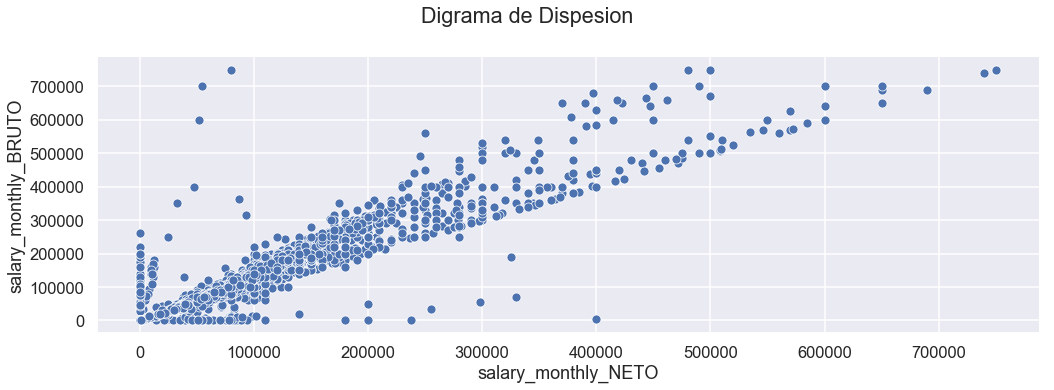

In [9]:
# Diagrama de Disperesion y Coeficiente de Correlacion
# se hace un filtro de los datos para apreciar mejor los valores cercanos a 0
bruto = df.salary_monthly_BRUTO < 800000
neto = df.salary_monthly_NETO < 800000
g=seaborn.pairplot(data=df[bruto & neto],
                 y_vars=['salary_monthly_BRUTO'],
                 x_vars=['salary_monthly_NETO'],
                 aspect=3, height=5)
g.fig.suptitle("Digrama de Dispesion", y=1.08)
seaborn.set(style="darkgrid")
# Coeficiente de Correlacion
relevant_columns = ['salary_monthly_BRUTO', 'salary_monthly_NETO']
df_salary = df[relevant_columns]
df_salary.corr(method ='spearman') 

Depuracion

In [10]:
## Ver si existen valores nulos

print('Filas nulas de Salary_bruto =',df.salary_monthly_BRUTO.isnull().sum())
print('Filas nulas de Salary_neto =',df.salary_monthly_NETO.isnull().sum())
#df1 = df[df.salary_monthly_BRUTO.isnull()]
#df2 = df[df.salary_monthly_NETO.isnull()]

## Eliminacion de outliers(aquellos casos que solo pueden ser interpretados como errores de carga):
# - quitamos aquellos casos que están por encima del percentil .98
# - quitamos aquellos casos que estan por debajo del monto = 10000 

max_limit_1 = df_salary["salary_monthly_NETO"].quantile(.98)
max_limit_2 = df_salary["salary_monthly_BRUTO"].quantile(.98)
min_limit_1 = 10000
min_limit_2 = 10000
df_curado = df_salary[(df_salary["salary_monthly_BRUTO"]<=max_limit_2) & (df_salary["salary_monthly_NETO"]<=max_limit_1)]
df_curado = df_salary[(df_salary["salary_monthly_BRUTO"]>=min_limit_2) & (df_salary["salary_monthly_NETO"]>=min_limit_1)]
print('Filas nulas de Salary_bruto =',df_curado.salary_monthly_BRUTO.isnull().sum())
print('Filas nulas de Salary_bruto =',df_curado.salary_monthly_NETO.isnull().sum())
#df1 = df_curado[df_curado.salary_monthly_BRUTO.isnull()]
#df2 = df_curado[df_curado.salary_monthly_NETO.isnull()]

Filas nulas de Salary_bruto = 0
Filas nulas de Salary_neto = 212
Filas nulas de Salary_bruto = 0
Filas nulas de Salary_bruto = 0


,salary_monthly_BRUTO,salary_monthly_NETO
salary_monthly_BRUTO,1.000000,0.963481
salary_monthly_NETO,0.963481,1.000000


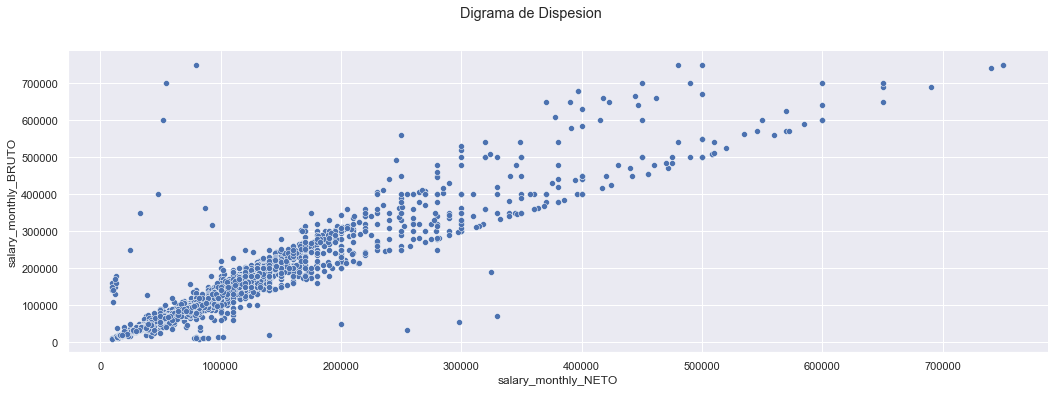

In [11]:
# Diagrama de Disperesion y Coeficiente de Correlacion
# se hace un filtro de los datos para apreciar mejor los valores cercanos a 0
bruto = df_curado.salary_monthly_BRUTO < 800000
neto = df_curado.salary_monthly_NETO < 800000
h=seaborn.pairplot(data=df_curado[bruto & neto],
                 y_vars=['salary_monthly_BRUTO'],
                 x_vars=['salary_monthly_NETO'],
                 aspect=3, height=5)
h.fig.suptitle("Digrama de Dispesion", y=1.08)
seaborn.set(style="darkgrid")
df_curado.corr(method ='spearman')

## c) Densidad condicional 

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable `'salary_monthly_NETO'`
¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación

In [12]:
import scipy

# Cargamos de nuevo el dataset completo
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

En esta seccion queremos responder la pregunta, **¿Hace falta terminar una carrera universitaria para tener un mejor salario en el sector IT?**.

Para esto vamos a considerar de las persona que contestaron las encuenta las que las que pusieron 'Universitario' en 'profile_studies_level'. De aca queremos sacamos dos subpoblaciones, las que tengan el nivel universitario completo y las que lo tengan incompleto. La variable categorica 'profile_studies_level_state' tiene tres posibles valores: 'Completado', 'En curso' e 'Incompleto', así que en un primer analisis vamos a considerar 'Incompleto' y 'En curso' como incompleto, asi quedan solo dos grupos. 

Chequeamos que estos sean suficientemente numerosos como para que tenga sentido el analisis.

In [13]:
relevant_columns = ['profile_studies_level', 'profile_studies_level_state', 'salary_monthly_NETO', 'profile_years_experience']
df = df[relevant_columns]

df_univ_complete = df[(df['profile_studies_level']=='Universitario') & 
                      (df['profile_studies_level_state']=='Completado')]
print('Cantidad de gente con nivel universitario completo:', len(df_univ_complete))

df_univ_incomplete = df[(df['profile_studies_level']=='Universitario') & 
                        ((df['profile_studies_level_state']=='Incompleto') | (df['profile_studies_level_state']=='En curso'))]
print('Cantidad de gente con nivel universitario incompleto o en curso:', len(df_univ_incomplete))

Cantidad de gente con nivel universitario completo: 1616
Cantidad de gente con nivel universitario incompleto o en curso: 2517


Para graficar los histogramas eliminamos las filas que tengan valor NaN en la columna 'salary_monthly_NETO', ya que no aportan informacion sobre lo que queremos analizar y producen error al intentar graficar.

Y para filtrar los outliers, como hicimos en el ejercicio 1, quitamos aquellos casos que están por encima del percentil .98 y por abajo de los 10000 pesos

In [14]:
# Filtramos
df_univ_complete = df_univ_complete.dropna(subset=['salary_monthly_NETO'])
df_univ_incomplete = df_univ_incomplete.dropna(subset=['salary_monthly_NETO'])

min_limit = 10000
max_limit_complete = df_univ_complete["salary_monthly_NETO"].quantile(.98)
max_limit_incomplete = df_univ_incomplete["salary_monthly_NETO"].quantile(.98)

df_univ_complete_filtered = df_univ_complete[(df_univ_complete["salary_monthly_NETO"]<=max_limit_complete) & 
                                             (df_univ_complete["salary_monthly_NETO"]>=min_limit)]
df_univ_incomplete_filtered = df_univ_incomplete[(df_univ_incomplete["salary_monthly_NETO"]<=max_limit_incomplete) 
                                                 & (df_univ_incomplete["salary_monthly_NETO"]>=min_limit)]

# Chequeamos que las cantidades sigan siendo significativas
print('Cantidad de gente con nivel universitario completo filtrado:', len(df_univ_complete_filtered))
print('Cantidad de gente con nivel universitario incompleto filtrado:', len(df_univ_incomplete_filtered))

Cantidad de gente con nivel universitario completo filtrado: 1490
Cantidad de gente con nivel universitario incompleto filtrado: 2296


Medias {'Completado': 100680.84895973153, 'Incompleto': 82903.34222996517}
Medianas {'Completado': 89894.0, 'Incompleto': 75000.0}


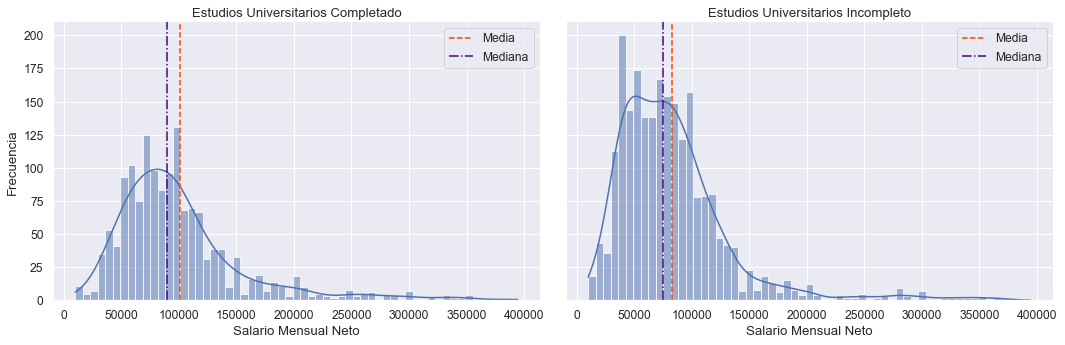

In [15]:
# Graficamos
seaborn.set_context('notebook', font_scale=1.1)
df_univ_incomplete_filtered2 = df_univ_incomplete_filtered.assign(profile_studies_level_state = 'Incompleto')
data = pd.concat([df_univ_complete_filtered, df_univ_incomplete_filtered2])
h = seaborn.displot(data, x="salary_monthly_NETO", col='profile_studies_level_state',aspect=1.5, kde=True)

h.set_axis_labels("Salario Mensual Neto", "Frecuencia")
h.set_titles("Estudios Universitarios {col_name}")

means = {'Completado':df_univ_complete_filtered.salary_monthly_NETO.mean(),
         'Incompleto':df_univ_incomplete_filtered2.salary_monthly_NETO.mean()}
medians = {'Completado':df_univ_complete_filtered.salary_monthly_NETO.median(),
           'Incompleto':df_univ_incomplete_filtered2.salary_monthly_NETO.median()}
print('Medias', means)
print('Medianas', medians)

for col_val, ax in h.axes_dict.items():
    ax.axvline(means[col_val], color='orangered', linestyle='--', label='Media')
    ax.axvline(medians[col_val], color='indigo', linestyle='-.', label='Mediana')
    ax.legend()

Calculamos las medidas de centralización y dispersión para cada subpoblación

In [16]:
df1 = df_univ_complete_filtered[['salary_monthly_NETO']].describe().round()
df1 = df1.rename(columns={'salary_monthly_NETO':'Universitario Completo'})

df2 = df_univ_incomplete_filtered2[['salary_monthly_NETO']].describe().round()
df2 = df2.rename(columns={'salary_monthly_NETO':'Universitario Incompleto'})

description = pd.concat([df1, df2], axis=1)
description

,Universitario Completo,Universitario Incompleto
count,1490.0,2296.0
mean,100681.0,82903.0
std,57137.0,49795.0
min,10000.0,11300.0
25%,65000.0,50000.0
50%,89894.0,75000.0
75%,117000.0,100000.0
max,394375.0,370000.0


Calculamos tambien el coeficiente de variación para comparar mejor la dispersion

In [17]:
print("Coeficiente de variación salario universitario completo:",
      scipy.stats.variation(df_univ_complete_filtered.salary_monthly_NETO))
print("Coeficiente de variación salario universitario incompleto:",
      scipy.stats.variation(df_univ_incomplete_filtered2.salary_monthly_NETO))

Coeficiente de variación salario universitario completo: 0.567312096882781
Coeficiente de variación salario universitario incompleto: 0.6005053186271528


Como podemos observar, la media y la mediana del salario del grupo con estudios universitarios completos son aproximadamente 20% mayor que la del grupo con estudios universitarios incompletos, con lo cual ambas variables no parecen ser independientes. Sin embargo, ¿fue correcta la decisión de agupar los que pusieron nivel universitario incompleto con los que pusieron en curso?. Ninguno termino la carrera, pero entendemos que 'incompleto' es gente que ya decidio despues de un tiempo que no la va a terminar, mientras que 'en curso' es gente que todavia esta estudiando. 

Entonces, veamos la distribucion de los tres grupos por separado

In [18]:
# Hacemos los cambios necesarios al codigo de filtrado de antes
df_univ_incomplete = df[(df['profile_studies_level']=='Universitario') & 
                        (df['profile_studies_level_state']=='Incompleto')]

df_univ_curso = df[(df['profile_studies_level']=='Universitario') & 
                   (df['profile_studies_level_state']=='En curso')]

df_univ_incomplete = df_univ_incomplete.dropna(subset=['salary_monthly_NETO'])
df_univ_curso = df_univ_curso.dropna(subset=['salary_monthly_NETO'])

min_limit = 10000
max_limit_incomplete = df_univ_incomplete["salary_monthly_NETO"].quantile(.98)
max_limit_curso = df_univ_curso["salary_monthly_NETO"].quantile(.98)

df_univ_incomplete_filtered = df_univ_incomplete[(df_univ_incomplete["salary_monthly_NETO"]<=max_limit_incomplete) &
                                                 (df_univ_incomplete["salary_monthly_NETO"]>=min_limit)]
df_univ_curso_filtered = df_univ_curso[(df_univ_curso["salary_monthly_NETO"]<=max_limit_curso) & 
                                             (df_univ_curso["salary_monthly_NETO"]>=min_limit)]

# Chequeamos que las cantidades sigan siendo significativas
print('Cantidad de gente con nivel universitario completo filtrado:', len(df_univ_complete_filtered))
print('Cantidad de gente con nivel universitario incompleto filtrado:', len(df_univ_incomplete_filtered))
print('Cantidad de gente con nivel universitario en curso filtrado:', len(df_univ_curso_filtered))

Cantidad de gente con nivel universitario completo filtrado: 1490
Cantidad de gente con nivel universitario incompleto filtrado: 1061
Cantidad de gente con nivel universitario en curso filtrado: 1234


Medias {'Completado': 100680.84895973153, 'Incompleto': 101317.81074458058, 'En curso': 68357.81893030793}
Medianas {'Completado': 89894.0, 'Incompleto': 87000.0, 'En curso': 62000.0}
Promedio años de experiencia {'Completado': 9.62275167785235, 'Incompleto': 11.26588124410933, 'En curso': 4.622690437601297}


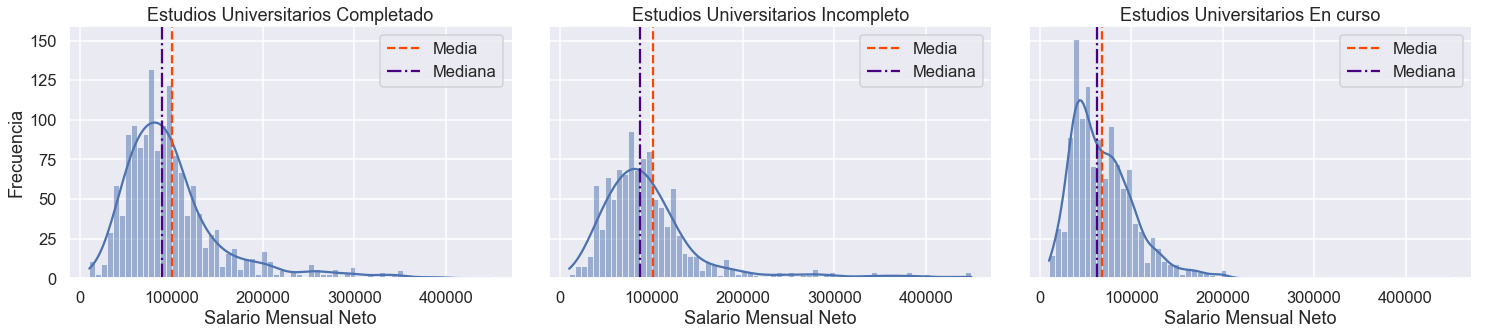

In [19]:
# Graficamos
seaborn.set_context('talk')
data = pd.concat([df_univ_complete_filtered, df_univ_incomplete_filtered, df_univ_curso_filtered])
h = seaborn.displot(data, x="salary_monthly_NETO", col='profile_studies_level_state', aspect=1.4, kde=True)

h.set_axis_labels("Salario Mensual Neto", "Frecuencia")
h.set_titles("Estudios Universitarios {col_name}")

means = {'Completado':df_univ_complete_filtered.salary_monthly_NETO.mean(),
         'Incompleto':df_univ_incomplete_filtered.salary_monthly_NETO.mean(),
         'En curso':df_univ_curso_filtered.salary_monthly_NETO.mean()}
medians = {'Completado':df_univ_complete_filtered.salary_monthly_NETO.median(),
           'Incompleto':df_univ_incomplete_filtered.salary_monthly_NETO.median(),
           'En curso':df_univ_curso_filtered.salary_monthly_NETO.median()}
experience = {'Completado':df_univ_complete_filtered.profile_years_experience.mean(),
              'Incompleto':df_univ_incomplete_filtered.profile_years_experience.mean(),
              'En curso':df_univ_curso_filtered.profile_years_experience.mean()}

print('Medias', means)
print('Medianas', medians)
print('Promedio años de experiencia', experience)

for col_val, ax in h.axes_dict.items():
    ax.axvline(means[col_val], color='orangered', linestyle='--', label='Media')
    ax.axvline(medians[col_val], color='indigo', linestyle='-.', label='Mediana')
    ax.legend()

Ahora podemos observar que en realidad las distribuciones de los grupos 'universitario completo' y 'universitario incompleto' son en realidad parecidas, con media y mediana muy similares, mientras que la de 'universitario en curso' es bastante distinta. De hecho si nos fijamos en el grafico anterior donde habiamos juntado a los grupos 'incompleto'y 'en curso' vemos que esa distribucion tenia como dos picos porque justamente estabamos mirando juntos dos grupos que separados tienen picos en dos lugares distintos.

Entonces pensamos, ¿que pueden tener en comun los integrantes de los grupos universitario completo e incompleto que no tengan los integrantes de universitario en curso? Una posible respuesta: Los años de experiencia. Los participantes de la encuesta que pusieron 'Universitario' y 'En curso' son probablemente estudiantes que recien se estan insertando en el campo laboral, mientras que los otros llevan ya mas tiempo en este. Esto lo podemos ver en el promedio de años de experiencia: 9.62 y 11.26 para univ. completo e incompleto, respectivamente y 4.62 para univ. en curso, menos de la mitad.

Con lo cual, a nuestro criterio, **la diferencia en salarios se debe a los años de experiencia y no depende de si uno tiene o no un titulo universitario**.

Por ultimo, matematicamente, dos variables son independientes si P(A|B) = P(A). Luego, si bien en la realidad esas dos probabilidades nunca van a ser completamente iguales, con lo cual no vamos a poder afirmar con seguridad que dos variables son totalmente independientes, si dan muy parecido nos habla de un cierto nivel de independencia.

Podemos calcular entonces la probabilidad de ganar mas que el promedio dado que tengo nivel universitario completo y compararla con la probabilidad de ganar mas que el promedio (no vamos a considerar a los que estan en curso, queremos ver solo la relacion entre los que pusieron completo e incompleto, que tienen en promedio similar cantidad de años de experiencia).

In [20]:
df_union = pd.concat([df_univ_complete_filtered, df_univ_incomplete_filtered])
avg_salary = df_union['salary_monthly_NETO'].mean()
prob_more_than_avg = len(df_union[df_union['salary_monthly_NETO']>avg_salary])/len(df_union)
print('Probabilidad de ganar mas que el promedio:', prob_more_than_avg)
prob_univ_complete = len(df_univ_complete_filtered)/len(df_union)
prob_intersection = len(df_univ_complete_filtered[df_univ_complete_filtered['salary_monthly_NETO']>avg_salary])/len(df_union)
print('Probabilidad de ganar mas que el promedio dado que tengo nivel universitario completo:', prob_intersection/prob_univ_complete)

Probabilidad de ganar mas que el promedio: 0.35829086632693063
Probabilidad de ganar mas que el promedio dado que tengo nivel universitario completo: 0.363758389261745


Como podemos ver, dan numeros muy parecidos, lo que apoya nuestra teoria de que el salario es practicamente independiente de si se termina o no una carrera universitaria que se empieza, y depende mas de otros factores como la cantidad de años de experiencia.